In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import logging
import numpy as np
import matplotlib.pyplot as plt
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from ML_util import *
import graphviz
from sklearn.tree import export_graphviz

2022-10-24 22:40:14.119078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_fwf('data.txt')

In [3]:
DF(df)

,classID,mX,mXgam,EX_P_Egam,Epis_D__E,Egam,p3L,cospisXga,cospisXga.1,mpisXgam_,mpisXgamL,Eg1,cosXgamg1,cosgamg1,5_T_TMath,weight,__run__,__event__,__candida,mcErrors,nROE_Ch,nROE_gam,Q_ROE,M_ROE,mcType,mcWrongB_,mcWrongB_.1,mcWrongB_.2,mcWrongB_.3,p3pisXgam,cosPhiG1,cospisXga.2,mQXGLw1,weight.1,BDT,LD,prob_LD
0,1,1.114384,1.597457,0.798955,0.104918,0.436953,1.091541,0.898671,0.481301,0.152195,2.536936,0.346149,0.608449,0.939752,-0.810607,1,2422,2914,0,188,7,17,-1,6.257174,511,1,0,3,9,1.567320,-0.883678,0.665655,2.868947,1,-0.079379,0.208172,0.371287
1,1,1.177904,1.341360,-0.089273,0.099872,0.105646,2.069337,0.936480,-0.637876,0.145648,3.725524,0.318065,-0.698832,0.728812,1.268494,1,2352,5034,0,188,5,7,1,5.912691,511,2,0,4,2,1.593726,0.895740,-0.684525,4.146674,1,-0.325572,0.118564,0.096730
2,1,1.663765,1.745303,1.778954,0.074090,0.157005,1.576703,0.981503,-0.996979,0.144828,4.786049,0.056783,-0.262819,-0.022129,1.775040,1,2300,8818,0,112,3,7,1,3.671306,0,0,0,0,0,1.206983,0.484229,-0.274443,4.848612,1,-0.268796,0.213469,0.393971
3,1,1.364490,1.630229,0.961167,0.101604,0.367103,1.109098,0.954375,-0.810736,0.148047,3.113335,0.324773,0.658844,0.923569,-3.378081,1,2461,5284,3,240,10,11,0,6.642709,521,0,0,0,0,0.668911,0.629448,0.678082,3.397122,1,-0.238372,0.207760,0.369545
4,1,0.933839,1.396383,0.544535,0.096198,0.333259,1.117779,0.712742,-0.667636,0.145053,2.654950,0.510867,0.034849,0.946476,-3.114568,1,3363,528,0,248,5,9,1,5.069966,511,1,1,4,2,0.841355,-0.616161,0.054056,3.099767,1,-0.352616,0.075289,0.049626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178667,1,1.342015,1.680473,0.418618,0.078991,0.221399,1.808094,0.832727,-0.577864,0.149354,3.748593,0.141921,-0.201380,0.709990,0.834703,1,2308,4860,0,120,9,9,1,5.753574,521,0,0,0,0,1.492552,0.080149,-0.166030,3.944489,1,-0.025427,0.247018,0.543230
178668,1,1.075125,1.511452,0.800938,0.075878,0.240395,1.457132,0.999700,-0.882335,0.146607,3.646888,0.350518,0.271935,0.891856,-0.394445,1,2342,911,0,112,4,8,0,3.693488,511,1,0,2,0,0.728953,-0.951719,0.271770,3.930458,1,-0.073011,0.197918,0.328910
178669,1,0.734908,1.525881,1.407813,0.077846,0.852375,1.398989,0.967174,-0.981614,0.148476,4.108222,0.639423,0.807936,0.983281,2.108125,1,2308,1730,0,176,6,9,0,4.901462,0,0,0,0,0,0.919081,-0.676787,0.816714,4.605923,1,-0.289544,0.179667,0.260345
178670,0,1.209801,1.701630,0.604202,0.086364,0.724059,1.571877,0.919173,-0.848134,0.144853,3.653393,0.258962,0.830871,0.951401,-0.958895,1,2535,1094,1,16,8,6,-2,4.756529,511,0,0,2,1,0.852346,0.951077,0.832456,3.893494,1,-0.027224,0.308531,0.757447


In [4]:
df.shape

(178672, 37)

# Load data

In [5]:
X = df.iloc[:,1:]
Y = df.iloc[:,0]

# Clean the data, remove the redundant features

In [6]:
X_clean = X.drop(columns = ['weight','weight.1','__run__','__event__','__candida'])

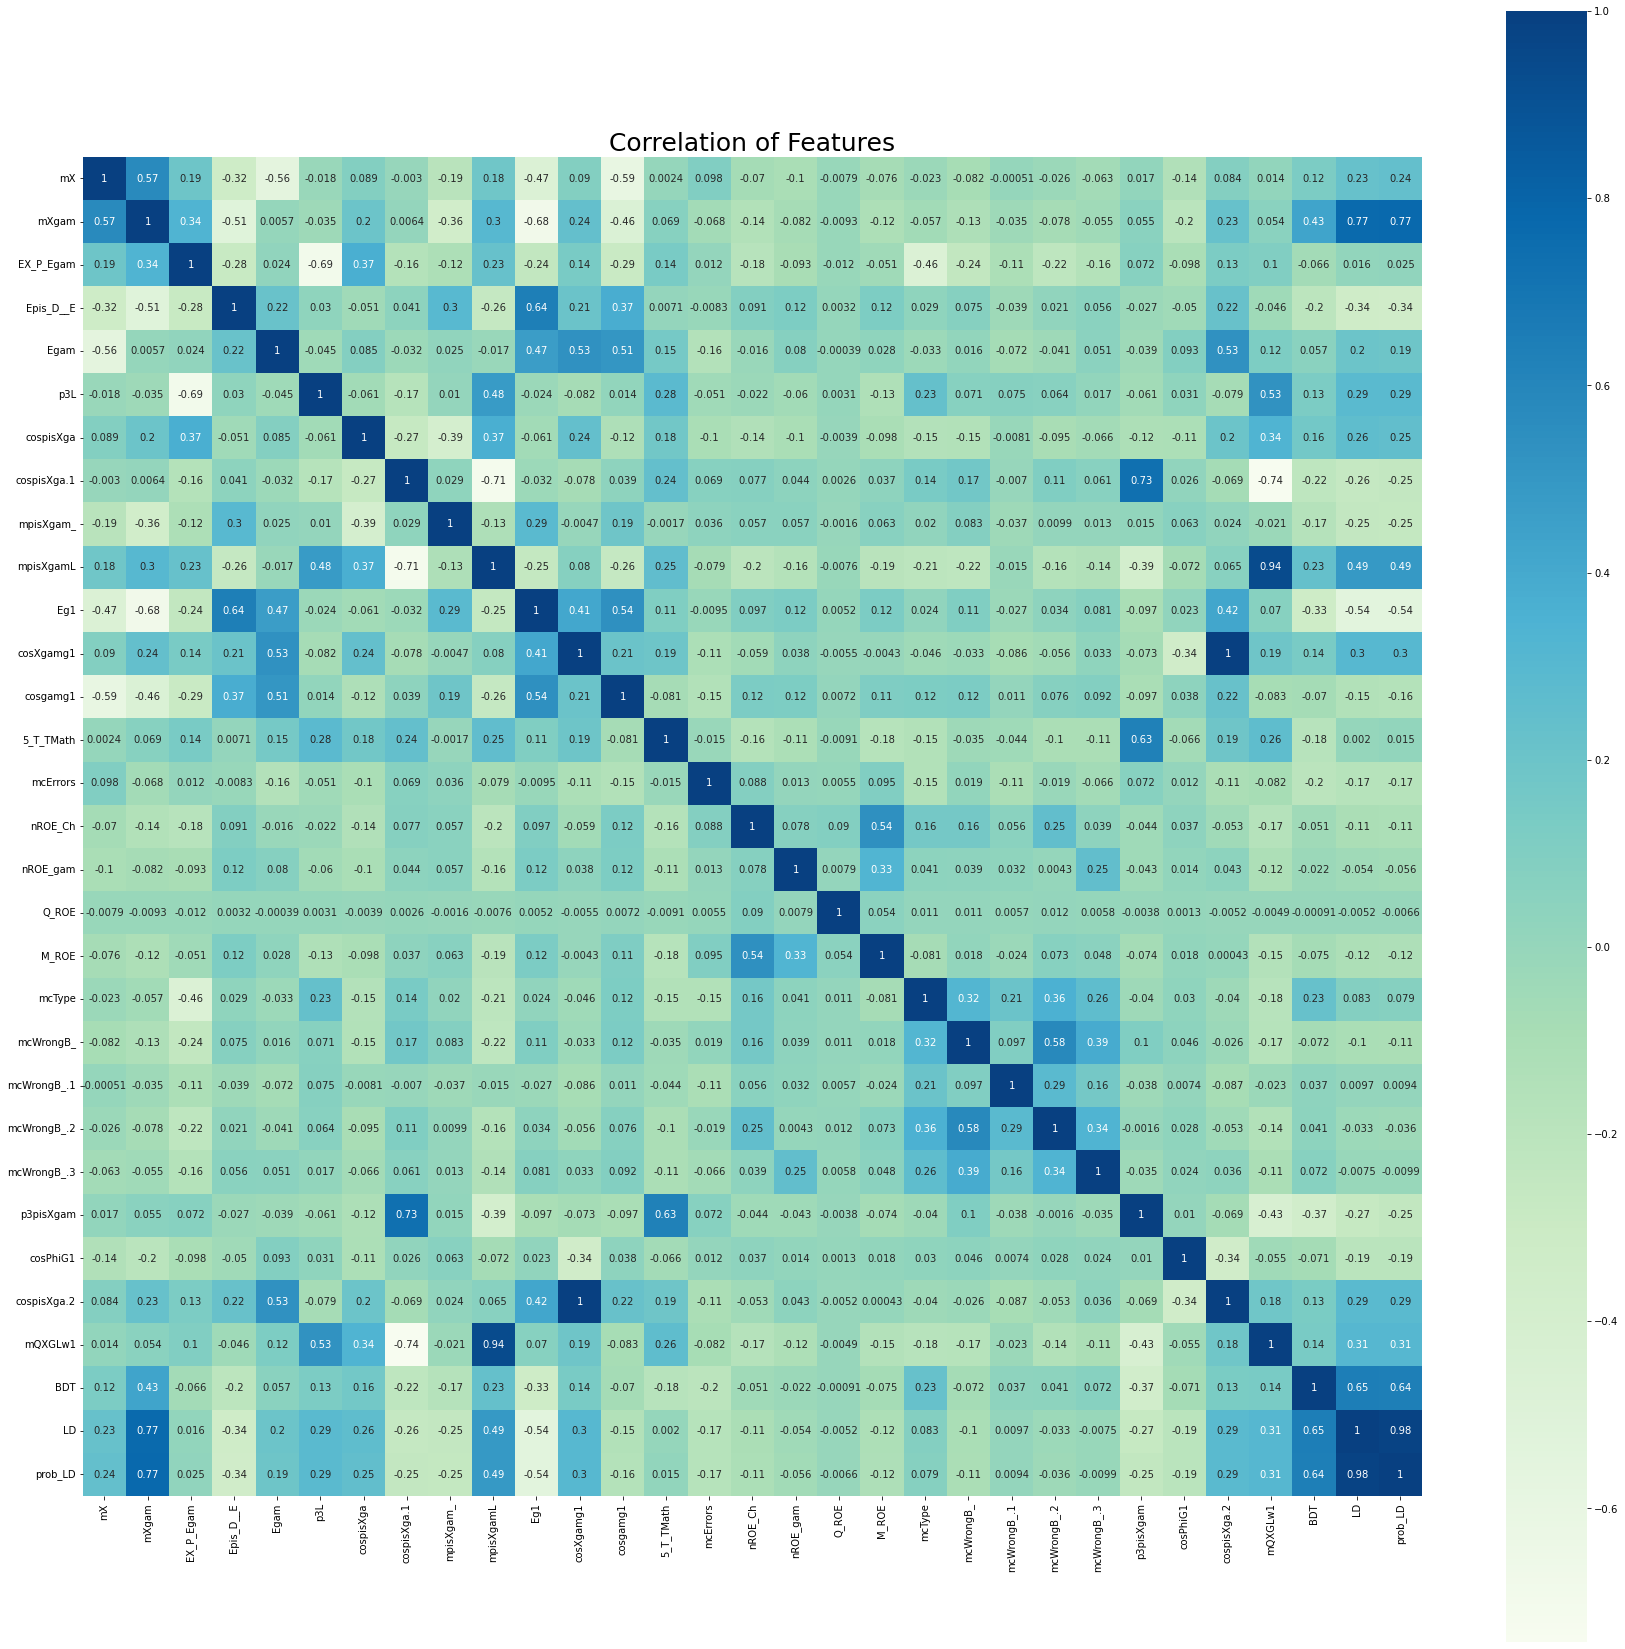

In [7]:
plt.figure(figsize=(30,30))
plt.title('Correlation of Features',size=25);
sns.heatmap(X_clean.corr(), linewidths=0, vmax=1.0, square=True, cmap='GnBu', annot=True)
plt.show()

In [8]:
x = X_clean.values  # load the input
y = Y.values # load the target

In [9]:
x.shape

(178672, 31)

In [10]:
y.shape

(178672,)

# Define the normalization function

In [11]:
def nom(x, scaler):
    fitter = scaler().fit(x) #use minmaxscaler
    y = fitter.transform(x)
    return y

# The distribution of all features for both zero and one signals.

In [12]:
x0 = x[y==0]
y0 = y[y==0]
print("number of zeros = ", y0.shape[0])

x1 = x[y==1]
y1 = y[y==1]
print("number of ones = ", y1.shape[0])

number of zeros =  14749
number of ones =  163923


In [13]:
x0_M = nom(x0, MinMaxScaler) # normalize the data
x1_M =nom(x1, MinMaxScaler)

In [14]:
n = x0.shape[1]

In [15]:
coa = np.array(X_clean.columns.tolist())

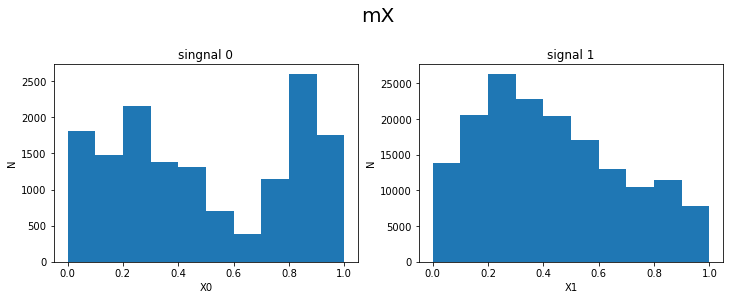

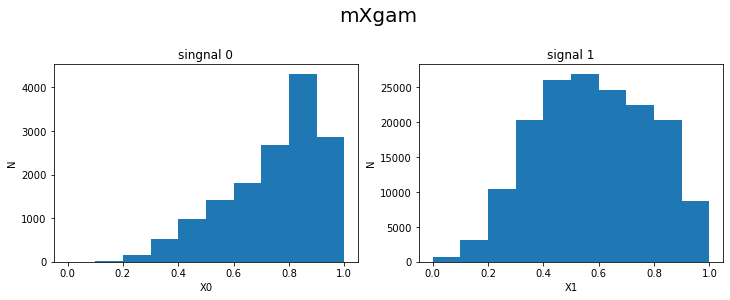

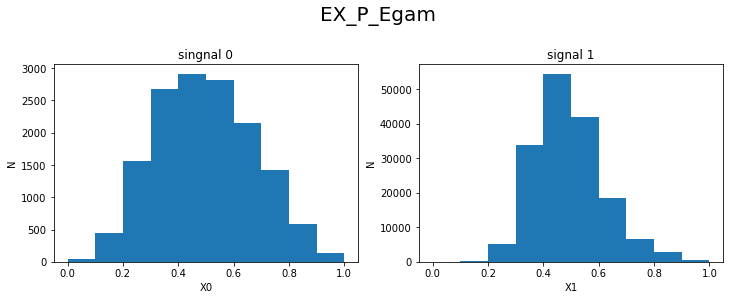

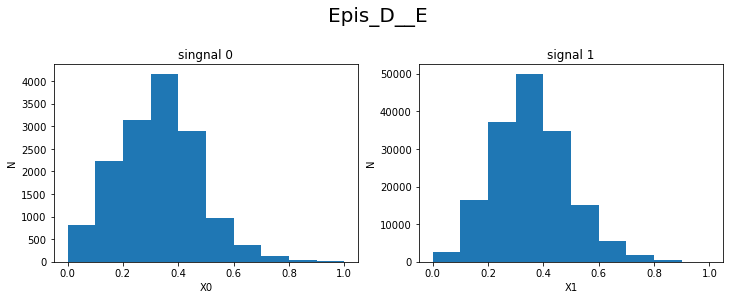

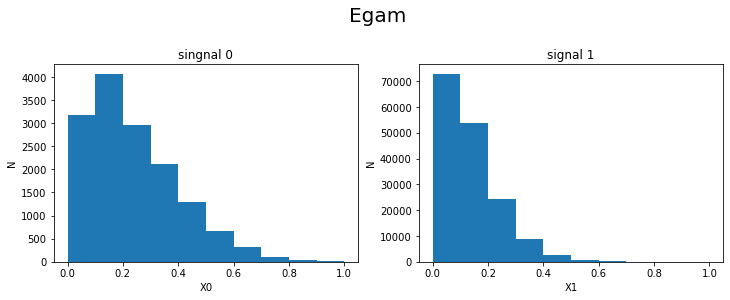

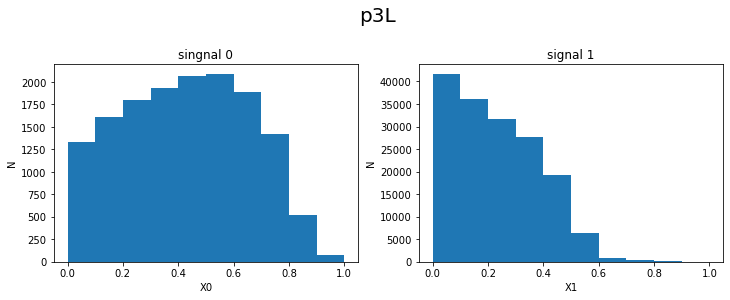

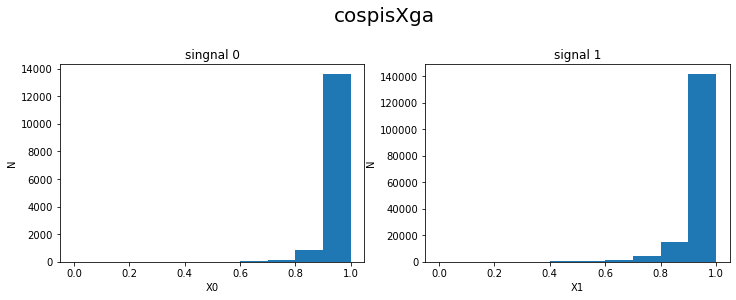

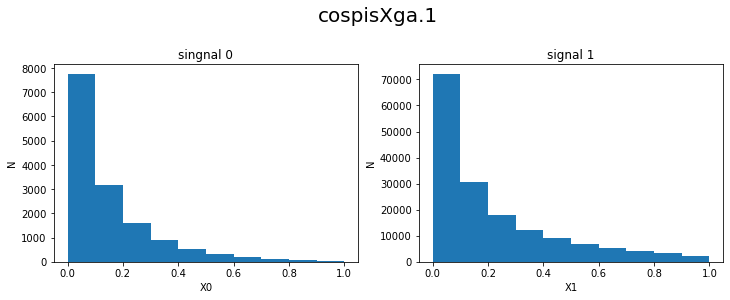

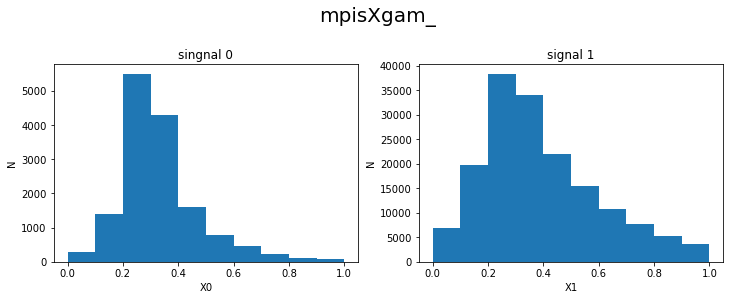

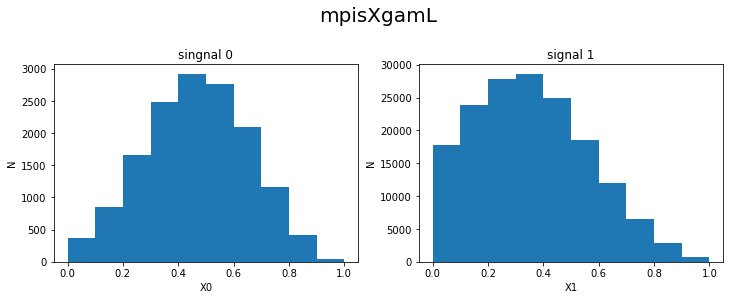

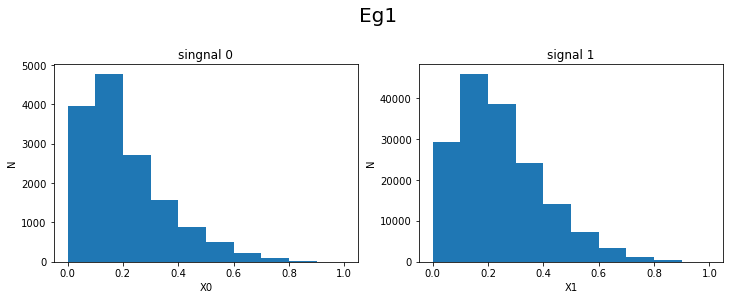

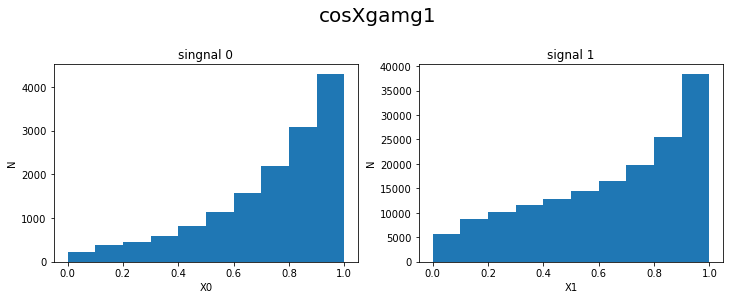

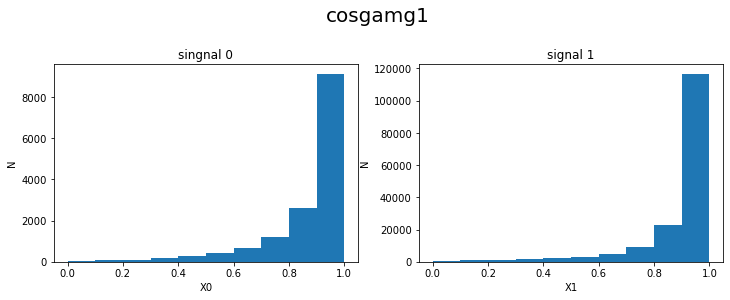

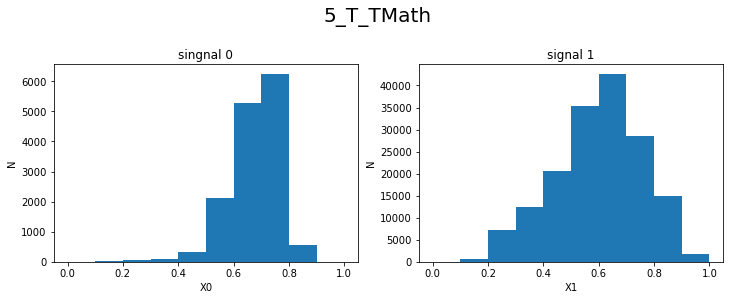

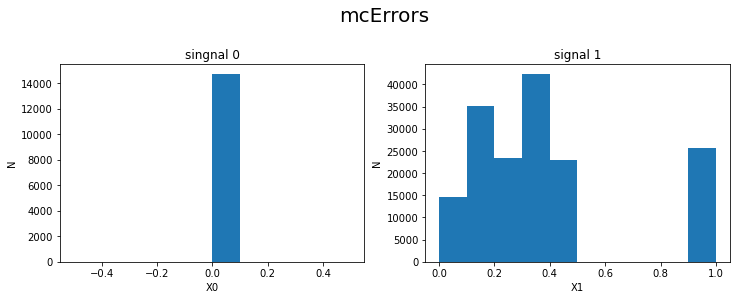

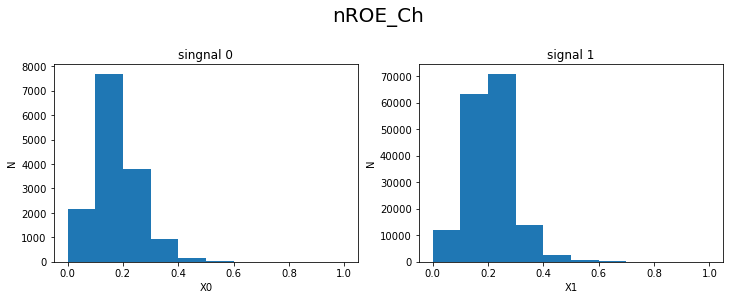

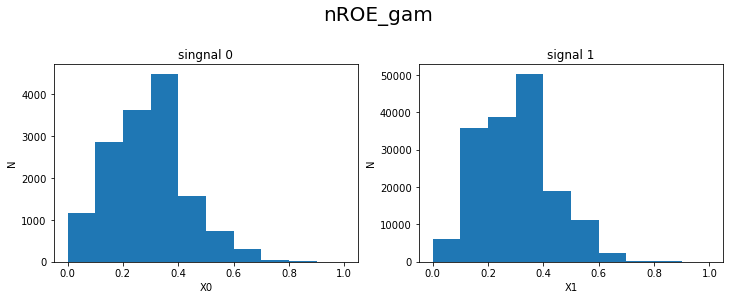

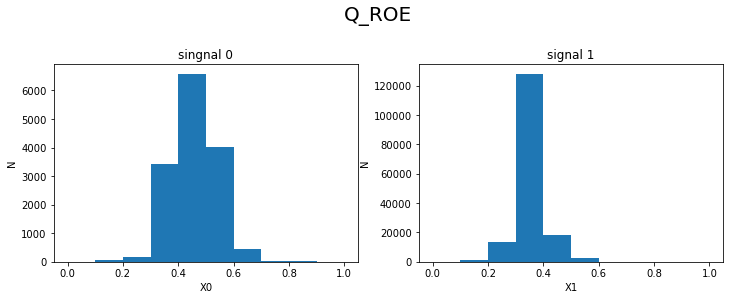

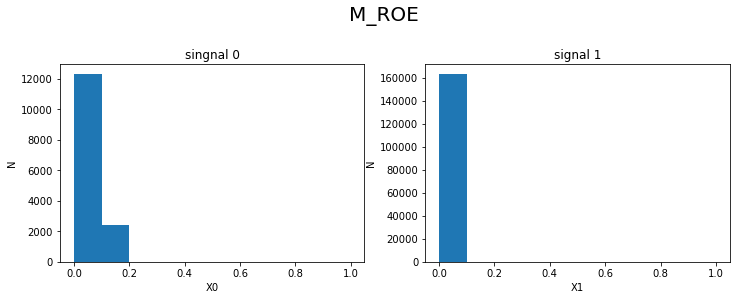

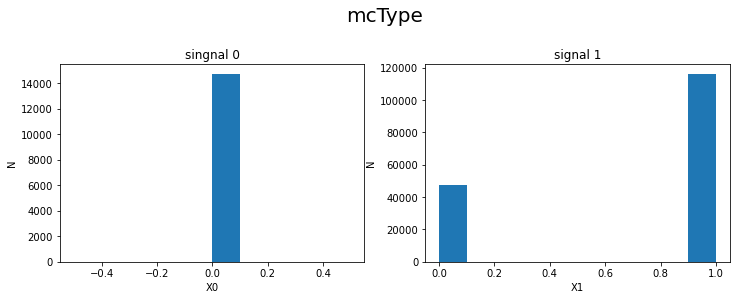

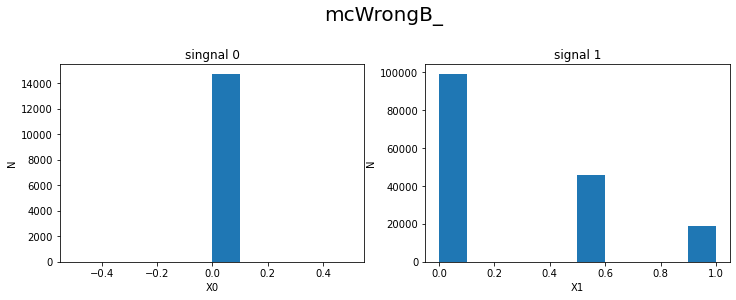

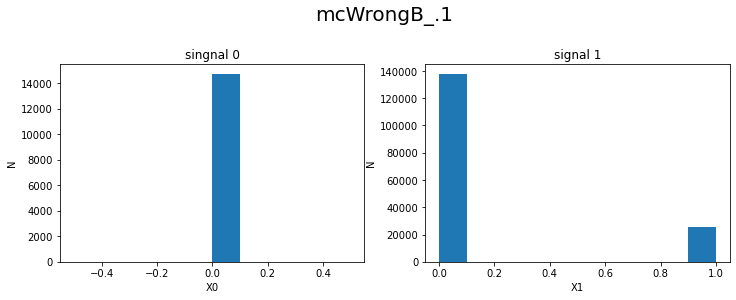

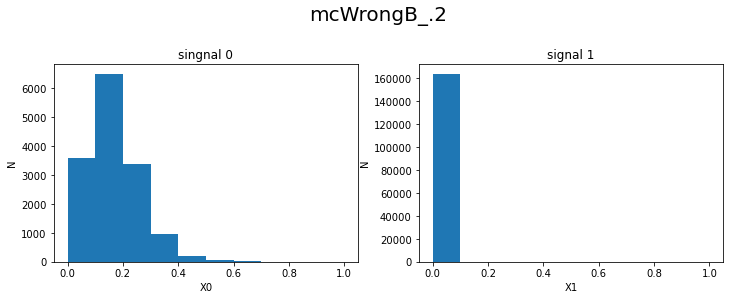

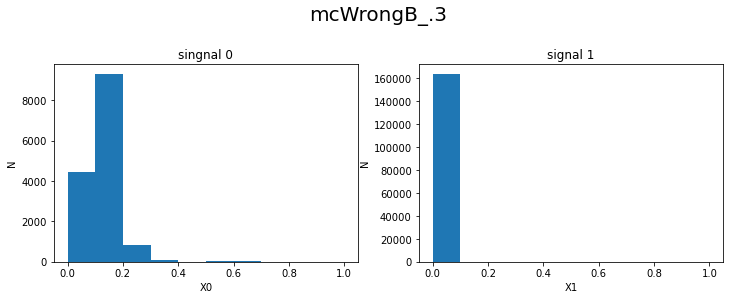

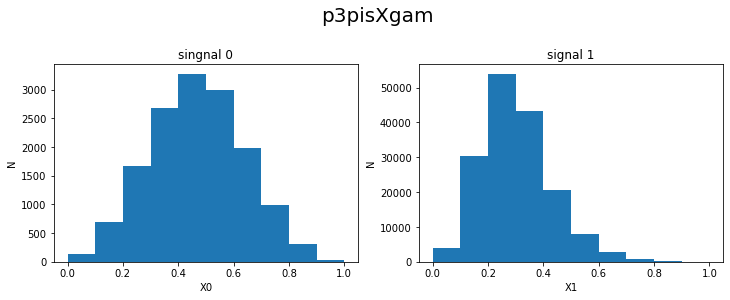

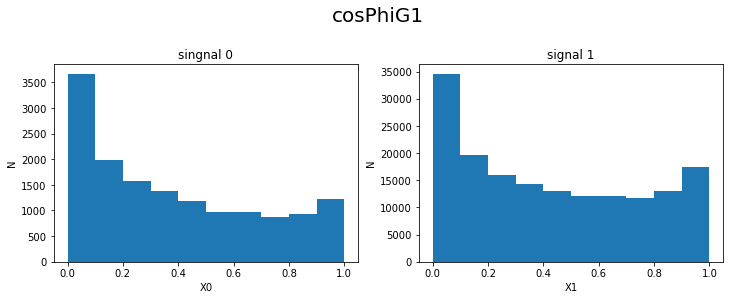

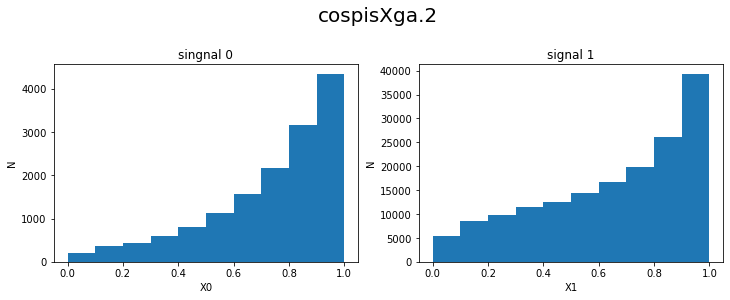

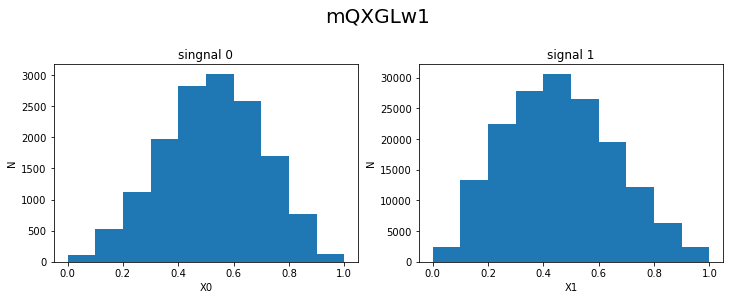

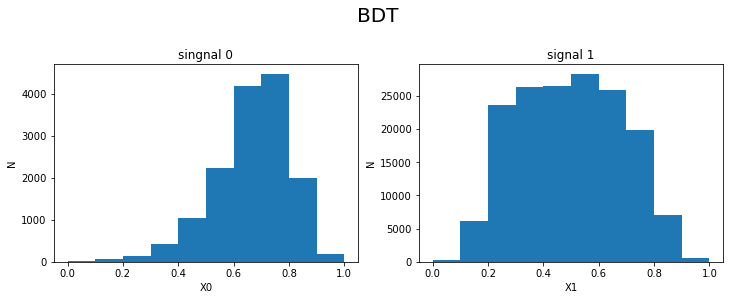

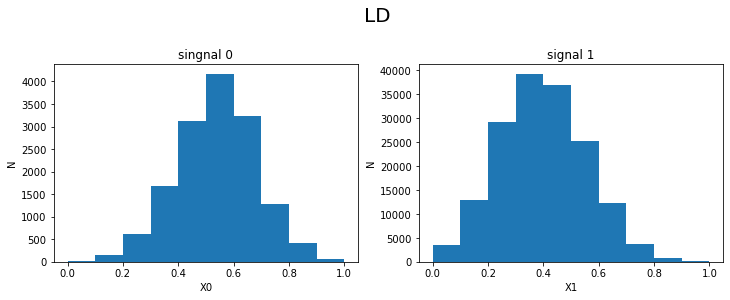

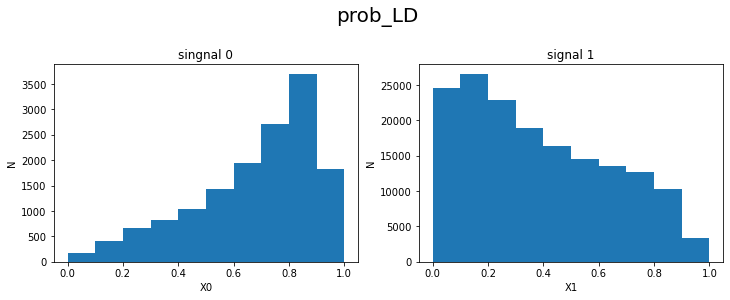

In [16]:
for i in range(n):
    plt.figure(figsize=(12, 8))
    
    plt.suptitle(coa[i],size =20)

    plt.subplot(2,2, 1)
    plt.hist(x0_M[:,i])
    plt.title('singnal 0')
    plt.ylabel('N')
    plt.xlabel("X0")


    plt.subplot(2,2,2)
    plt.hist(x1_M[:,i])
    plt.title('signal 1')
    plt.ylabel('N')
    plt.xlabel("X1")
    plt.show()

In [17]:
def balance(x,y):
    X,Y = NearMiss().fit_resample(x,y)
    return X,Y

In [18]:
xx,yy = balance(x,y)

In [19]:
np.mean(yy==0)

0.5

# Applying RandomForrest

In [20]:
xx_tr,xx_te,yy_tr, yy_te = train_test_split(xx,yy,test_size = 0.2)

sc = StandardScaler()
xx_tr_S = sc.fit_transform(xx_tr)
xx_te_S = sc.transform(xx_te)

MM = MinMaxScaler()
xx_tr_M = MM.fit_transform(xx_tr)
xx_te_M = MM.transform(xx_te)

In [21]:
RFclass = RandomForestClassifier(n_estimators = 100, criterion='gini',max_depth = 20,min_samples_leaf=10,
                                max_features='auto')

RFmodel = RFclass.fit(xx_tr_M, yy_tr)

Py_tr_prob = RFmodel.predict_proba(xx_tr_M)
Py_tr = RFmodel.predict(xx_tr_M)

Py_te_prob = RFmodel.predict_proba(xx_te_M)
Py_te = RFmodel.predict(xx_te_M)

In [22]:
ys = Y.replace({1:'detect',0:'non-detect'})

In [23]:
estimator = RFmodel.estimators_[5]
dot_data = export_graphviz(estimator, out_file = 'RF.dot', feature_names = coa\
                    ,class_names = sorted(ys.unique()), rounded = True, filled = True)
path = 'RF.dot'
s = graphviz.Source.from_file(path)

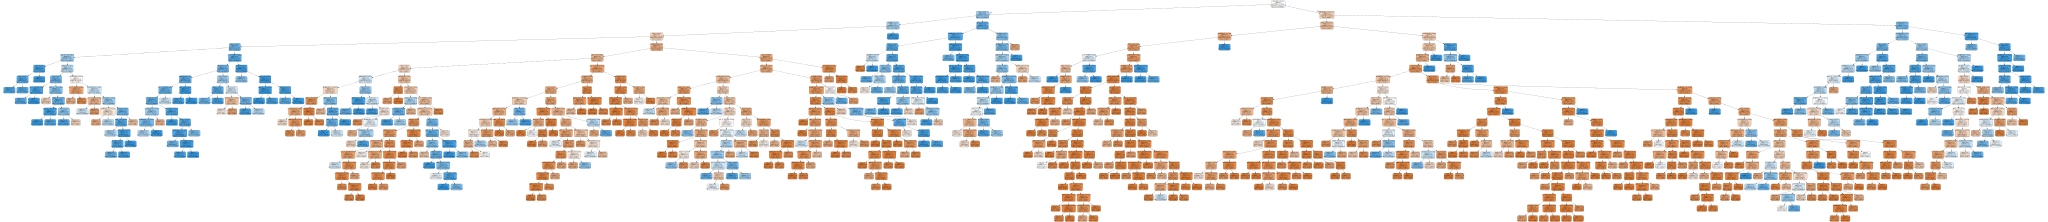

In [24]:
s

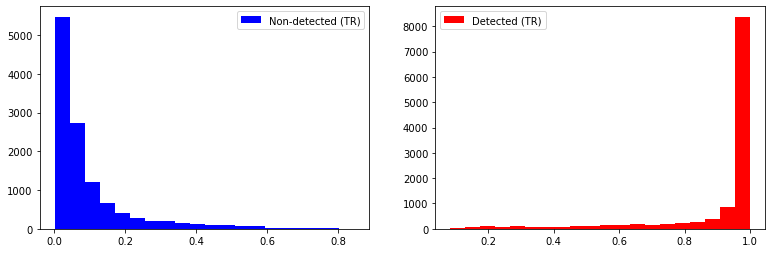

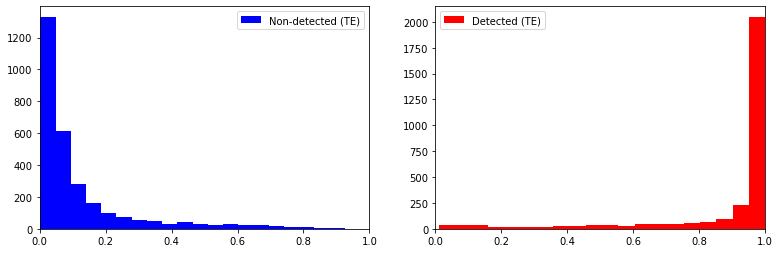

In [25]:
fig = plt.figure(figsize=(13, 9))

plt.subplot(2, 2, 1)
plt.hist(Py_tr_prob[np.where(yy_tr == 0)[0],1],20,color = "blue",)
plt.legend(['Non-detected (TR)'])

plt.subplot(2, 2, 2)
plt.hist(Py_tr_prob[np.where(yy_tr == 1)[0],1],20,color = "red",)
plt.legend(['Detected (TR)'])

plt.show()

fig = plt.figure(figsize=(13, 9))
plt.subplot(2, 2, 1)
plt.hist(Py_te_prob[np.where(yy_te == 0)[0],1],20,color = "blue",)
plt.xlim([0,1])
plt.legend(['Non-detected (TE)'])

plt.subplot(2, 2, 2)
plt.hist(Py_te_prob[np.where(yy_te == 1)[0],1],20,color = "red",)
plt.xlim([0,1])
plt.legend(['Detected (TE)'])
plt.show()

Text(0.5, 1.0, 'Area Under the Curve = 0.993')

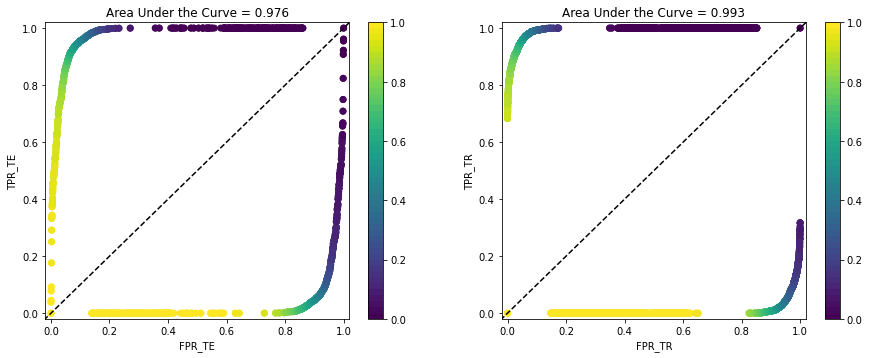

In [26]:
fpr_te = dict()
tpr_te = dict()
T_te = dict()
roc_auc_te = dict()

for i in range(2):
    tpr_te[i], fpr_te[i], T_te[i] = roc_curve(yy_te, Py_te_prob[:,i])
    roc_auc_te[i] = auc(fpr_te[i], tpr_te[i])


    
    
fig = plt.figure(figsize=(15, 12))


plt.subplot(2, 2, 1)
cmap = plt.cm.get_cmap("viridis",50)
plt.scatter(fpr_te[1], tpr_te[1], c=T_te[1],cmap=cmap,vmin=0.,vmax=1)
plt.scatter(fpr_te[0], tpr_te[0], c=T_te[0],cmap=cmap,vmin=0.,vmax=1)
plt.colorbar()
plt.plot([-0.2,1.2],[-0.2,1.2], '--k')
plt.xlim([-.02,1.02])
plt.ylim([-.02,1.02])

plt.xlabel('FPR_TE')
plt.ylabel('TPR_TE')
plt.title('Area Under the Curve = %.3f' %roc_auc_te[0])



fpr_tr = dict()
tpr_tr = dict()
T_tr = dict()
roc_auc_tr = dict()

for i in range(2):
    tpr_tr[i], fpr_tr[i], T_tr[i] = roc_curve(yy_tr, Py_tr_prob[:,i])
    roc_auc_tr[i] = auc(fpr_tr[i], tpr_tr[i])


plt.subplot(2, 2, 2)
cmap = plt.cm.get_cmap("viridis",50)
plt.scatter(fpr_tr[1], tpr_tr[1], c=T_tr[1],cmap=cmap,vmin=0.,vmax=1)
plt.scatter(fpr_tr[0], tpr_tr[0], c=T_tr[0],cmap=cmap,vmin=0.,vmax=1)
plt.colorbar()
plt.plot([-0.2,1.2],[-0.2,1.2], '--k')
plt.xlim([-.02,1.02])
plt.ylim([-.02,1.02])

plt.xlabel('FPR_TR')
plt.ylabel('TPR_TR') 
plt.title('Area Under the Curve = %.3f' %roc_auc_tr[0])


In [27]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 25)
    plt.colorbar()
    plt.tick_marks = np.arange(len(classes))
    plt.xticks(plt.tick_marks, classes, rotation=45)
    plt.yticks(plt.tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 20)
    plt.xlabel('Predicted label', size = 20)

Normalized confusion matrix
[[0.95 0.05]
 [0.1  0.9 ]]


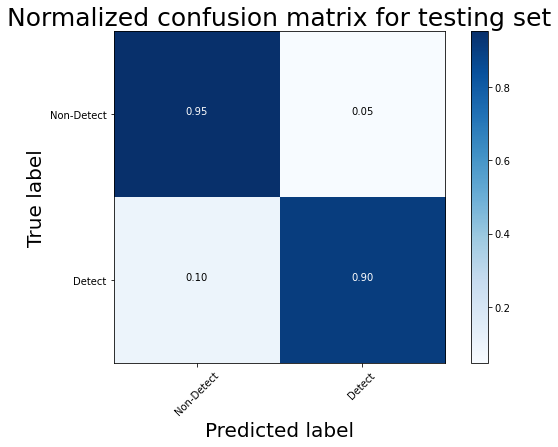

Normalized confusion matrix
[[0.98 0.02]
 [0.07 0.93]]


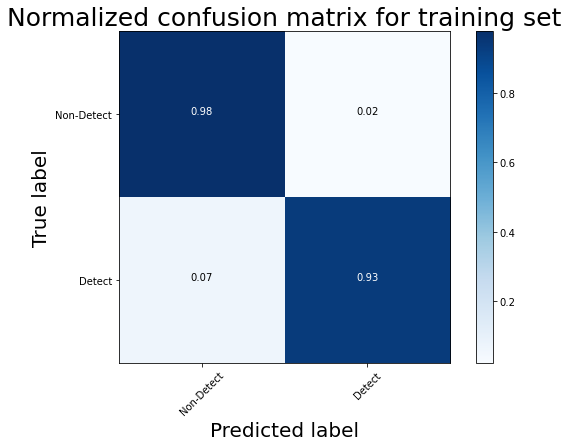

In [28]:
cnf_matrix = confusion_matrix(yy_te,Py_te)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Non-Detect', 'Detect'], normalize=True,
                      title='Normalized confusion matrix for testing set')

plt.show()

cnf_matrix = confusion_matrix(yy_tr,Py_tr)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Non-Detect', 'Detect'], normalize=True,
                      title='Normalized confusion matrix for training set')

plt.show()

In [29]:
weight = pd.DataFrame(RFclass.feature_importances_)
weight = weight.set_index(coa)
weight = weight.set_axis(['weight'], axis=1)

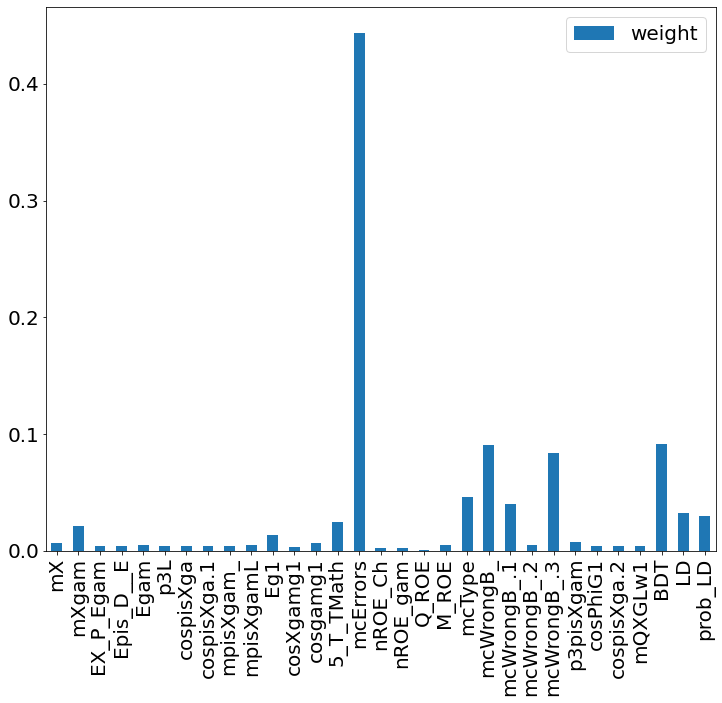

In [30]:
weight.plot(kind='bar',figsize=(12,10),fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

# Select significant features

In [31]:
nf =weight.loc[(weight['weight']>0.05)]

In [32]:
nfa = nf.index.values

In [33]:
nfa

array(['mcErrors', 'mcWrongB_', 'mcWrongB_.3', 'BDT'], dtype=object)

In [34]:
x_n= df[nfa]

In [35]:
x_n.shape

(178672, 4)

In [36]:
x_n.corr()

,mcErrors,mcWrongB_,mcWrongB_.3,BDT
mcErrors,1.000000,0.019188,-0.066018,-0.203031
mcWrongB_,0.019188,1.000000,0.389284,-0.071589
mcWrongB_.3,-0.066018,0.389284,1.000000,0.072181
BDT,-0.203031,-0.071589,0.072181,1.000000


In [37]:
nidx = np.array([X_clean.columns.get_loc(i) for i in nfa])

In [38]:
xn_tr = xx_tr[:,nidx] 
xn_te = xx_te[:,nidx]
xn = xx[:,nidx]

xn_tr_M = xx_tr_M[:,nidx]
xn_te_M = xx_te_M[:,nidx]

xn_tr_S = xx_tr_S[:,nidx]
xn_te_S = xx_te_S[:,nidx]

In [39]:
xn.shape

(29498, 4)

In [40]:
xn_tr.shape

(23598, 4)

In [41]:
yy_tr.shape

(23598,)

# Training Neutral Network

In [42]:
x_tr,x_te,y_tr, y_te = train_test_split(x_n.values,y,test_size = 0.4)

In [43]:
print("x_tr.shape:", x_tr.shape, "x_te.shape:", x_te.shape)

x_tr.shape: (107203, 4) x_te.shape: (71469, 4)


In [44]:
sc = StandardScaler()
x_tr_S = sc.fit_transform(x_tr)
x_te_S = sc.transform(x_te)

MM = MinMaxScaler()
x_tr_M = MM.fit_transform(x_tr)
x_te_M = MM.transform(x_te)

In [45]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(x_tr.shape[1],)),
    Dense(8, activation="sigmoid"),
    Dense(4, activation="sigmoid"),
    Dense(1, activation="linear"),
    ] ,name = "Signal_classifier" )

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

2022-10-24 22:41:26.099799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [46]:
model.summary()

Model: "Signal_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(x_tr, y_tr, batch_size = 32, epochs = 20)

Epoch 1/20
3351/3351 [==============================] - 3s 817us/step - loss: 0.1978 - accuracy: 0.8949
Epoch 2/20
3351/3351 [==============================] - 3s 840us/step - loss: 0.0433 - accuracy: 0.9848
Epoch 3/20
3351/3351 [==============================] - 3s 829us/step - loss: 0.0353 - accuracy: 0.9865
Epoch 4/20
3351/3351 [==============================] - 3s 819us/step - loss: 0.0338 - accuracy: 0.9868
Epoch 5/20
3351/3351 [==============================] - 3s 802us/step - loss: 0.0333 - accuracy: 0.9870
Epoch 6/20
3351/3351 [==============================] - 3s 802us/step - loss: 0.0328 - accuracy: 0.9871
Epoch 7/20
3351/3351 [==============================] - 3s 849us/step - loss: 0.0324 - accuracy: 0.9872
Epoch 8/20
3351/3351 [==============================] - 3s 944us/step - loss: 0.0320 - accuracy: 0.9872
Epoch 9/20
3351/3351 [==============================] - 3s 1ms/step - loss: 0.0315 - accuracy: 0.9873
Epoch 10/20
3351/3351 [==============================] - 4s 1ms/st

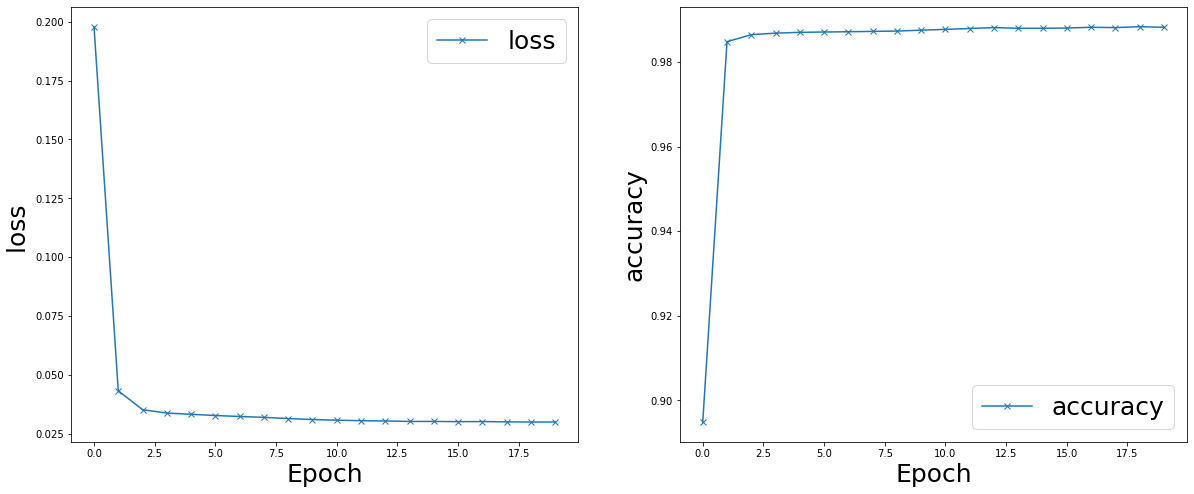

In [48]:
plot_loss_tf(history)

In [49]:
bc_eva(model,x_te,y_te)

2234/2234 [==============================] - 1s 593us/step
accuracy =  0.9878688662217185


(0.9878688662217185, 65023, 5579, 334, 533)

In [50]:
bc_eva(model,xn_tr,yy_tr)

738/738 [==============================] - 0s 585us/step
accuracy =  0.9330027968471905


(0.9330027968471905, 10787, 11230, 609, 972)

In [51]:
bc_eva(model,xn_te,yy_te)

185/185 [==============================] - 0s 629us/step
accuracy =  0.9264406779661017


(0.9264406779661017, 2720, 2746, 164, 270)